In [2]:
from ema_workbench import load_results,  Policy, MultiprocessingEvaluator
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.util import ema_logging
from ema_workbench.analysis import feature_scoring
import seaborn as sns

In [2]:
scen_file = ["genscen_Gorssel_50000_12-06-2021-03-06-15.tar.gz", "genscen_Overijssel_50000_12-06-2021-02-18-42.tar.gz", "genscen_Deventer_50000_12-06-2021-02-25-33.tar.gz"]
actor = ["Gorssel", "Overijssel", "Deventer"]
costs = ["Gorssel", "Gorssel and Deventer", "Deventer"]
n_scen = 100

zero_policy = {'DaysToThreat': 0}
zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in range(3)})
zero_policy.update({'RfR {}'.format(n): 0 for n in range(3)})

fs_actors = []
ema_logging.log_to_stderr(ema_logging.INFO)

for i in range(3):
    experiments, outcomes = load_results("simulation/generated/" + scen_file[i])
    dike_model, planning_steps = get_model_for_problem_formulation(actor[i])
    uncertainties = [uncertainty.name for uncertainty in dike_model.uncertainties]
    x = experiments[uncertainties]
    outcomes_df = pd.DataFrame(outcomes)

    pol0 = {}

    for key in dike_model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy('Policy 0', **pol0)

    with MultiprocessingEvaluator(dike_model) as evaluator:
        sobol_results = evaluator.perform_experiments(scenarios=n_scen, policies=policy0, uncertainty_sampling=SOBOL)
        
    x,y = sobol_results
    y.pop(costs[i] + " Total Costs")
    
    fs_actors.append(feature_scoring.get_feature_scores_all(x, y, alg='extra trees'))

[MainProcess/INFO] results loaded succesfully from D:\juju\modelbaseddecisionmaking\FabiosDecisions\epa1361\final assignment\simulation\generated\genscen_Gorssel_50000_12-06-2021-03-06-15.tar.gz
[MainProcess/INFO] pool started
[MainProcess/INFO] performing 7600 scenarios * 1 policies * 1 model(s) = 7600 experiments
[MainProcess/INFO] 760 cases completed
[MainProcess/INFO] 1520 cases completed
[MainProcess/INFO] 2280 cases completed
[MainProcess/INFO] 3040 cases completed
[MainProcess/INFO] 3800 cases completed
[MainProcess/INFO] 4560 cases completed
[MainProcess/INFO] 5320 cases completed
[MainProcess/INFO] 6080 cases completed
[MainProcess/INFO] 6840 cases completed
[MainProcess/INFO] 7600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis bec

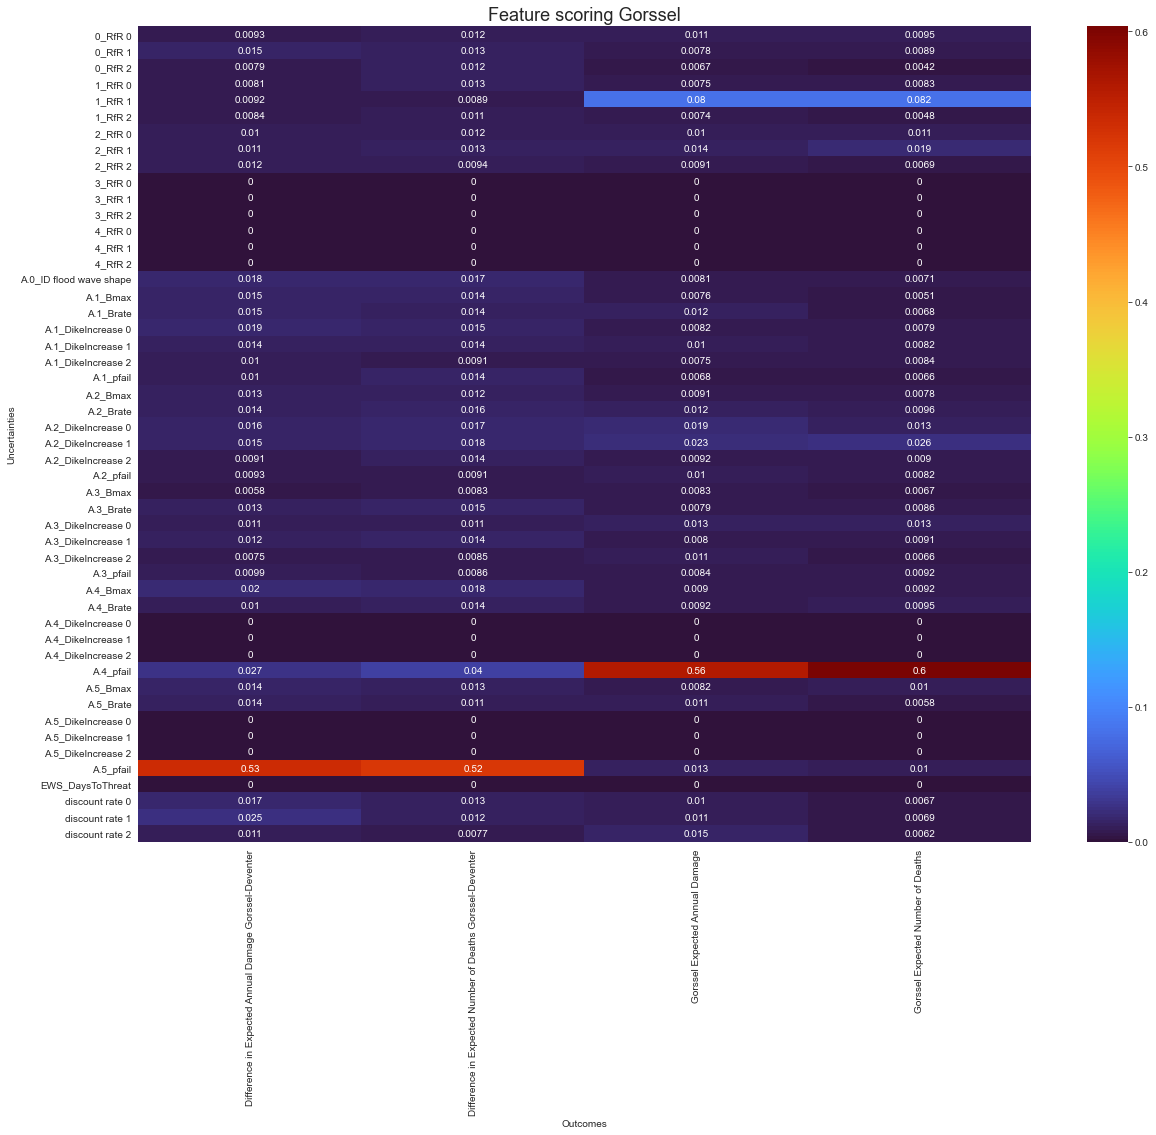

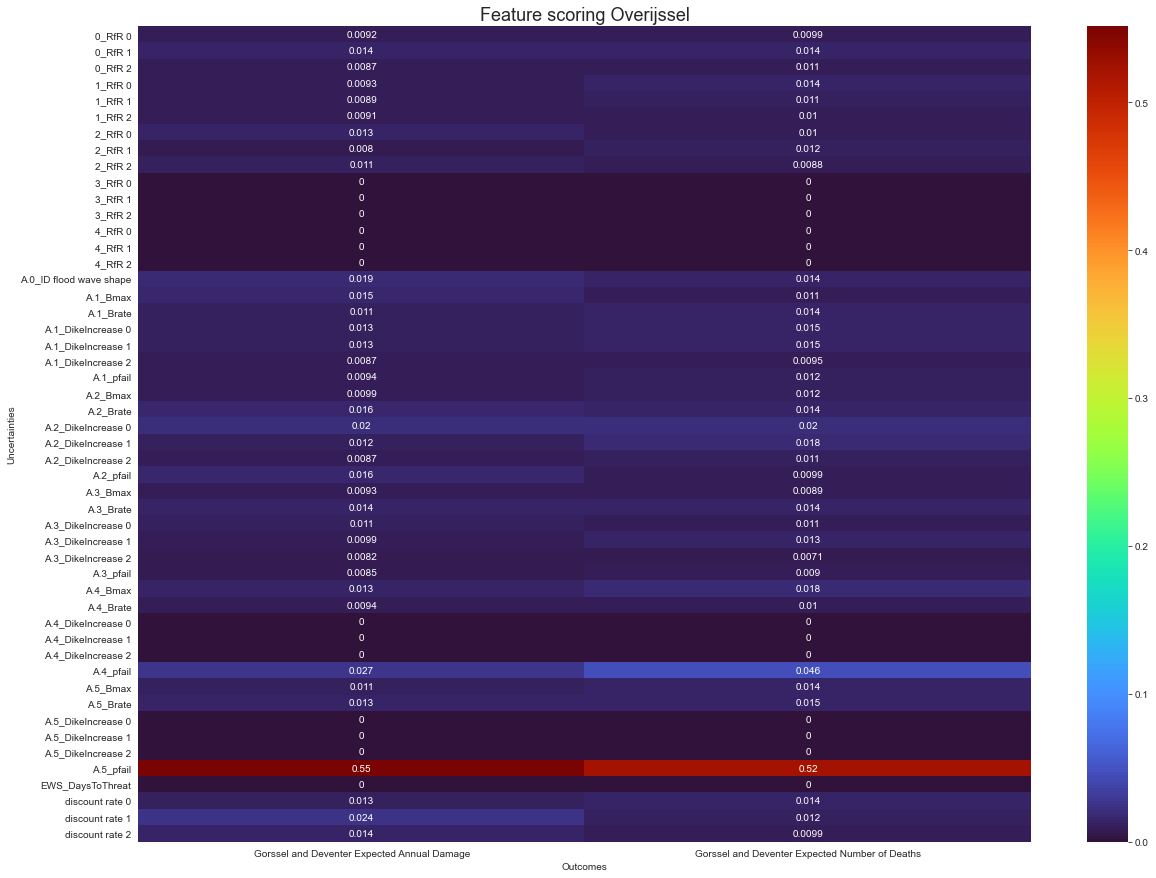

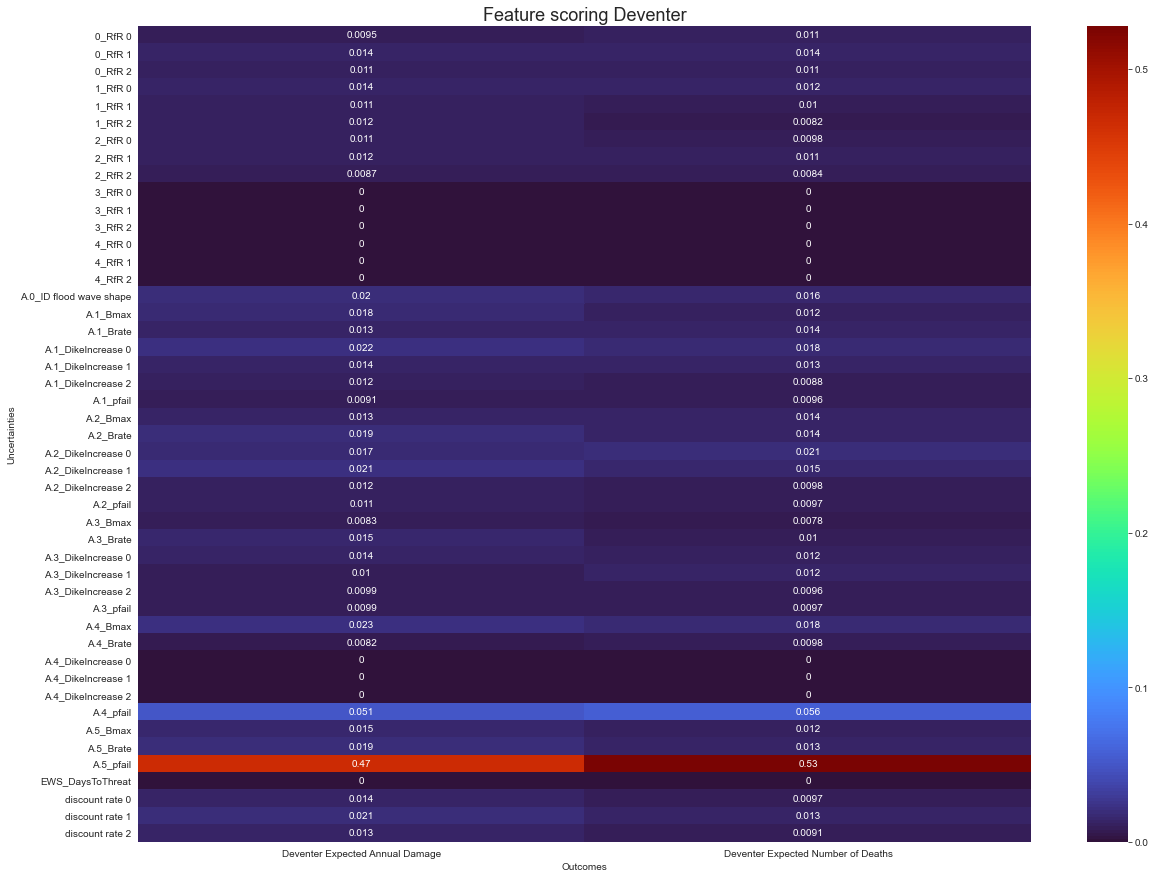

In [3]:
# Set up figure
i=0
for fs in fs_actors:
    sns.set_style('white')
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 15)

    sns.heatmap(fs, cmap='turbo', annot=True, ax=ax)
    ax.set_title('Feature scoring ' + actor[i], fontsize=18)
    ax.set(xlabel='Outcomes', ylabel='Uncertainties')
    plt.savefig("../../report/figures/results/sa_model_" + actor[i] + ".png", bbox_inches="tight")
    plt.show()
    
    i+= 1

In [26]:
#Gorssel
fs_actors[0].sort_values(by="Gorssel Expected Annual Damage", ascending=False).head(3)

,Difference in Expected Annual Damage Gorssel-Deventer,Difference in Expected Number of Deaths Gorssel-Deventer,Gorssel Expected Annual Damage,Gorssel Expected Number of Deaths
0,,,,
A.4_pfail,0.027075,0.039729,0.560524,0.603676
1_RfR 1,0.009203,0.008906,0.080403,0.081548
A.2_DikeIncrease 1,0.015105,0.017980,0.022786,0.025774


In [28]:
# Overijssel
fs_actors[1].sort_values(by="Gorssel and Deventer Expected Annual Damage", ascending=False).head(3)

,Gorssel and Deventer Expected Annual Damage,Gorssel and Deventer Expected Number of Deaths
0,,
A.5_pfail,0.551419,0.522769
A.4_pfail,0.026993,0.045817
discount rate 1,0.023897,0.012288


In [29]:
#Deventer
fs_actors[2].sort_values(by="Deventer Expected Annual Damage", ascending=False).head(3)

,Deventer Expected Annual Damage,Deventer Expected Number of Deaths
0,,
A.5_pfail,0.467080,0.527580
A.4_pfail,0.050624,0.056352
A.4_Bmax,0.022584,0.018269


The values are estimator instance, it clearly shows that A4_pfail and A4_Pfail are the most relevant predictors for the outcomes.
For all actors: Only A.4 and/or A.5's pfail $\geq$ 0.5 for damage. The second value is always $<$ 0.081

In [4]:
i=0
for fs in fs_actors:
    fs.to_csv("simulation/sa/"+actor[i]+".csv", index=True)
    i+=1

# Reading all results in again, to put into heatmaps

In [3]:
fs = {}
for actor in ["Deventer", "Gorssel", "Overijssel"]:
    fs[actor] = pd.read_csv("simulation/sa/"+ actor +".csv")
    fs[actor].set_index("0", inplace=True)

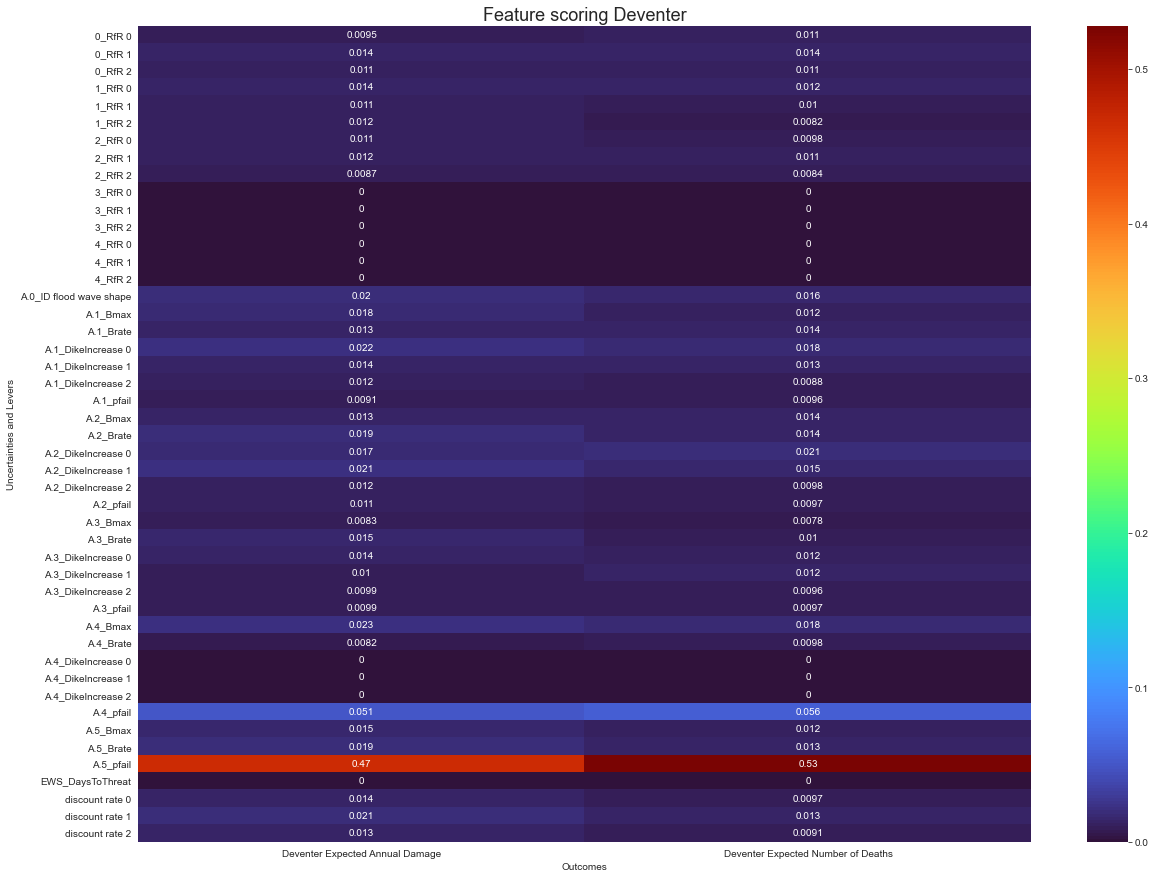

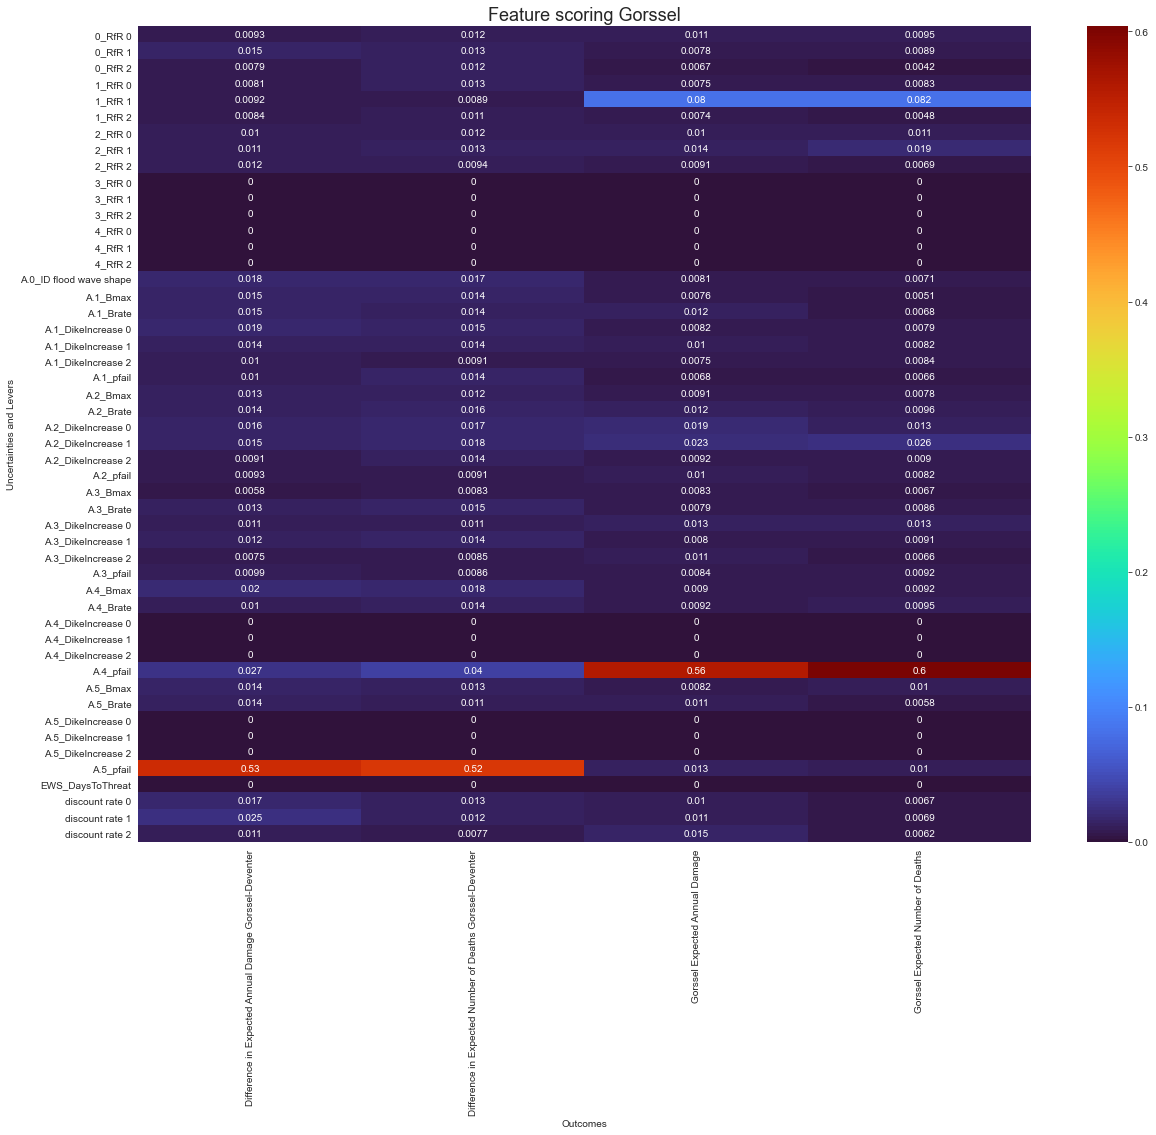

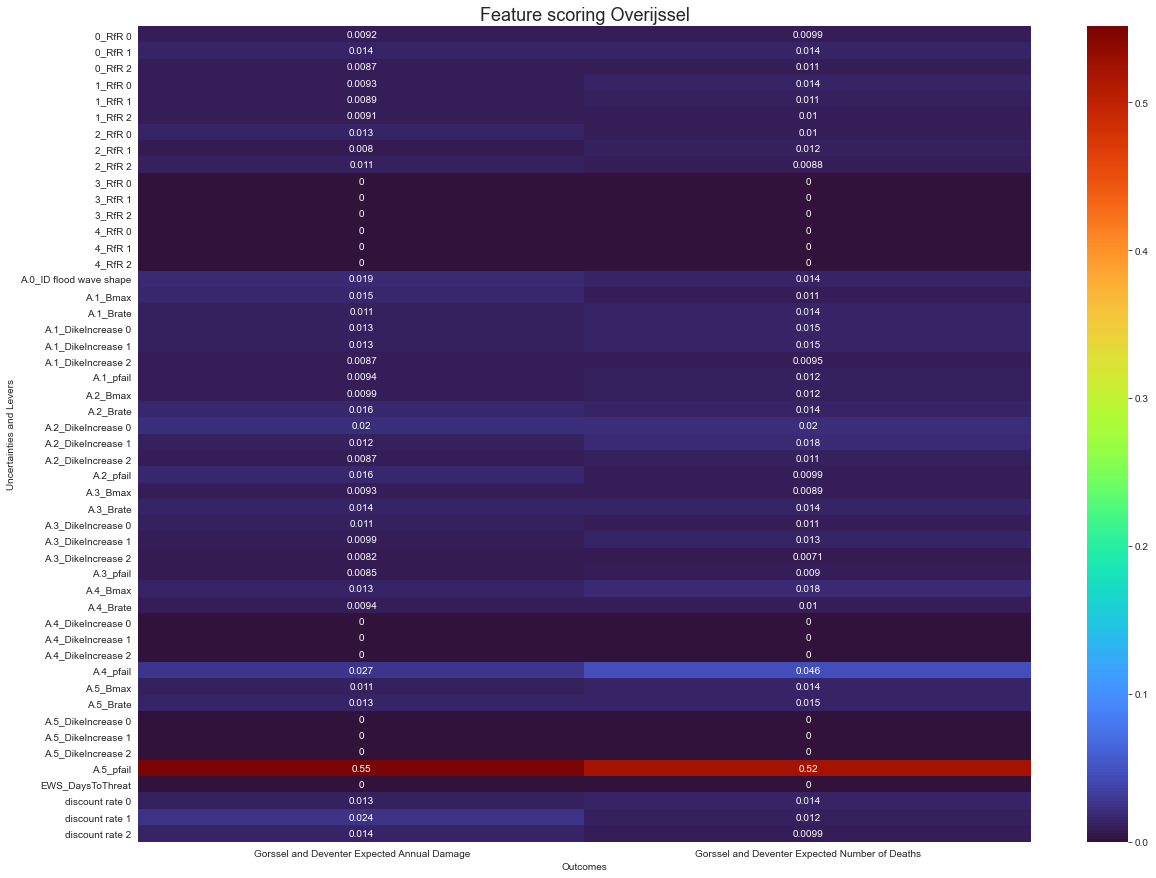

In [5]:
# Set up figure
for actor, fs in fs.items():
    sns.set_style('white')
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 15)

    sns.heatmap(fs, cmap='turbo', annot=True, ax=ax)
    ax.set_title('Feature scoring ' + actor, fontsize=18)
    ax.set(xlabel='Outcomes', ylabel='Uncertainties and Levers')
    plt.savefig("../../report/figures/results/sa_model_" + actor + ".png", bbox_inches="tight")
    plt.show()    